<a href="https://colab.research.google.com/github/denncraft/Primers/blob/master/%5BTitanic%5D_Linear_model_and_neural_net_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [593]:
import os
from pathlib import Path
import json
import torch, numpy as np, pandas as pd
import numpy as np
from torch import tensor
from fastai.data.transforms import RandomSplitter


path = Path('sample_data')
np.set_printoptions(linewidth=200)
torch.set_printoptions(linewidth=200, sci_mode=False, edgeitems=7)
torch_seed = 442
pd.set_option('display.width', 200)


In [594]:
def prepare_data(data):
  modes = data.mode().iloc[0]
  data.fillna(modes, inplace=True)
  data.isna().sum()

  data['LogFare'] = np.log(data['Fare']+1)

  data = pd.get_dummies(data, columns=["Sex","Pclass","Embarked"])
  indep_cols = ['Age', 'SibSp', 'LogFare'] + data.filter(regex='.*_.*').columns.to_list()
  return data, indep_cols

df, indep_cols = prepare_data(pd.read_csv(path/'train.csv'))

In [595]:
t_dep = tensor(df.Survived)
t_indep = tensor(df[indep_cols].values, dtype=torch.float)

In [596]:
torch.manual_seed(torch_seed)
n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
t_indep*coeffs
vals,_ = t_indep.max(dim=0)
t_indep = t_indep / vals
preds = (t_indep * coeffs).sum(axis=1)
loss = torch.abs(preds - t_dep).mean()

In [597]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

In [598]:
coeffs.requires_grad_()
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()

with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5447)


In [599]:
splitter_proportion = 0.15
splitter_seed=42

train_split, validation_split=RandomSplitter(valid_pct=splitter_proportion, seed=splitter_seed)(df)

trn_indep = t_indep[train_split]
trn_dep   = t_dep[train_split]

val_indep = t_indep[validation_split]
val_dep   = t_dep[validation_split]
# len(trn_indep), len(val_indep)

In [600]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")
    return loss

def train_model(epochs=30, lr=0.01):
    torch.manual_seed(torch_seed)
    coeffs = init_coeffs()
    for i in range(epochs):
      loss = one_epoch(coeffs, lr=lr)
    return coeffs, loss

def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))

coeffs, last_loss = train_model(epochs=30, lr=0.5)
# show_coeffs()
coeffs_for_test = coeffs
coeffs

0.561; 0.478; 0.411; 0.362; 0.393; 0.342; 0.407; 0.403; 0.484; 0.375; 0.399; 0.306; 0.368; 0.379; 0.517; 0.349; 0.421; 0.331; 0.411; 0.356; 0.508; 0.344; 0.423; 0.303; 0.381; 0.378; 0.521; 0.339; 0.447; 0.314; 

tensor([-0.2222, -0.0718,  0.4525,  0.2448, -0.2408,  0.3410,  0.3148,  0.3241,  0.2086,  0.0780,  0.2578], requires_grad=True)

In [601]:
threshold = 1-last_loss

def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>threshold)).float().mean()
acc(coeffs)

tensor(0.8195)

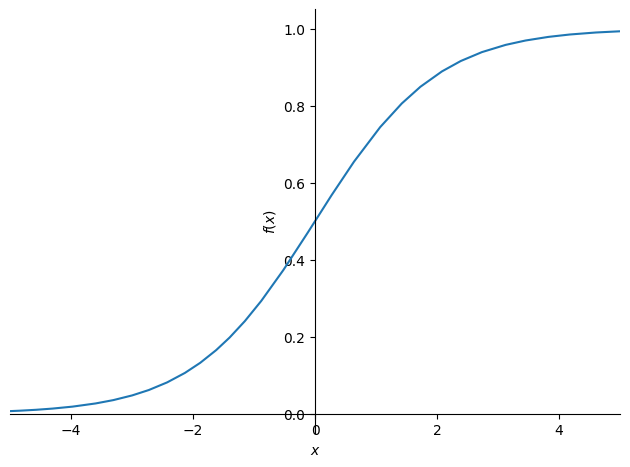

In [602]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

In [603]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))
coeffs, _ = train_model(6, lr=100)
acc(coeffs)

0.514; 0.325; 0.268; 0.209; 0.204; 0.201; 

tensor(0.8346)

In [604]:
show_coeffs()

{'Age': tensor(-1.4033),
 'SibSp': tensor(-0.5337),
 'LogFare': tensor(0.8492),
 'Sex_female': tensor(7.5921),
 'Sex_male': tensor(-9.9387),
 'Pclass_1': tensor(3.1833),
 'Pclass_2': tensor(2.0097),
 'Pclass_3': tensor(-6.5637),
 'Embarked_C': tensor(1.1294),
 'Embarked_Q': tensor(0.0619),
 'Embarked_S': tensor(-2.9975)}

In [605]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)
def init_coeffs(): return (torch.rand(n_coeff, 1)-0.5).requires_grad_()

trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

coeffs, _ = train_model(6, lr=100)
acc(coeffs)

0.514; 0.325; 0.268; 0.209; 0.204; 0.201; 

tensor(0.8346)

In [606]:
show_coeffs()

{'Age': tensor([-1.4033]),
 'SibSp': tensor([-0.5337]),
 'LogFare': tensor([0.8492]),
 'Sex_female': tensor([7.5921]),
 'Sex_male': tensor([-9.9387]),
 'Pclass_1': tensor([3.1833]),
 'Pclass_2': tensor([2.0097]),
 'Pclass_3': tensor([-6.5637]),
 'Embarked_C': tensor([1.1294]),
 'Embarked_Q': tensor([0.0619]),
 'Embarked_S': tensor([-2.9975])}

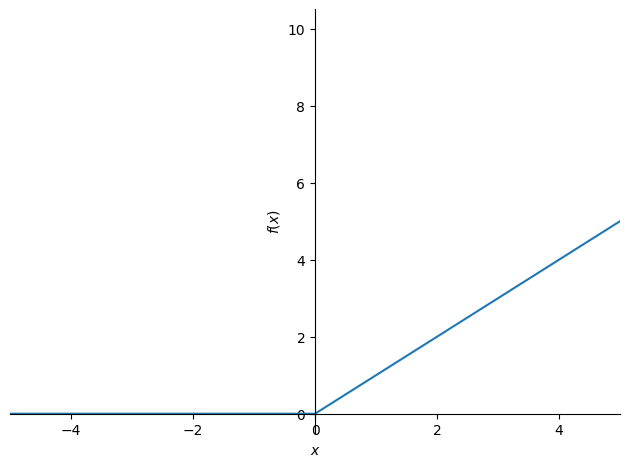

In [607]:
sympy.plot("max(0,x)", xlim=(-5,5));

In [608]:
import torch.nn.functional as F
hidden_layer_size = 20
magic_const1 = 0.5
magic_const2 = 0.3

def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-magic_const1)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-magic_const2
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

def train_model(epochs=30, lr=0.01, hls=20):
    torch.manual_seed(torch_seed)
    coeffs = init_coeffs(hls)
    for i in range(epochs):
      one_epoch(coeffs, lr=lr)
    return coeffs

coeffs = train_model(lr=100, hls=hidden_layer_size)
acc(coeffs)

0.550; 0.358; 0.583; 0.333; 0.224; 0.214; 0.331; 0.227; 0.546; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 

tensor(0.8195)

In [609]:
import torch.nn.functional as F

def init_coeffs():
    hiddens = [10, 10]                # <-- установите размер каждого скрытого слоя
    sizes = [n_coeff] + hiddens + [1] # --> [11, 10, 10, 1]
    n = len(sizes)                    # --> 4
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

def train_model(epochs=30, lr=0.01):
    torch.manual_seed(torch_seed)
    coeffs = init_coeffs()
    for i in range(epochs):
      one_epoch(coeffs, lr=lr)
    return coeffs

coeffs = train_model(lr=0.5)
acc(coeffs)

0.550; 0.474; 0.441; 0.411; 0.387; 0.365; 0.344; 0.323; 0.296; 0.274; 0.260; 0.250; 0.243; 0.239; 0.235; 0.232; 0.230; 0.228; 0.226; 0.224; 0.223; 0.222; 0.220; 0.219; 0.218; 0.217; 0.216; 0.215; 0.214; 0.214; 

tensor(0.8346)

In [619]:
df_test = pd.read_csv(path/'test.csv')
df_surv = pd.read_csv(path/'test_survived.csv')
df_test, indep_cols = prepare_data(df_test)

t_dep = tensor(df_surv.Survived)
t_indep = tensor(df_test[indep_cols].values, dtype=torch.float)
vals,_ = t_indep.max(dim=0)
t_indep = t_indep / vals

# coeffs = torch.tensor([-0.2222, -0.0718,  0.4525,  0.2448, -0.2408,  0.3410,  0.3148,  0.3241,  0.2086,  0.0780,  0.2578])
print(threshold, coeffs_for_test)

tensor(0.6863, grad_fn=<RsubBackward1>) tensor([-0.2222, -0.0718,  0.4525,  0.2448, -0.2408,  0.3410,  0.3148,  0.3241,  0.2086,  0.0780,  0.2578], requires_grad=True)


In [611]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))
calc_preds(coeffs_for_test, t_indep)

tensor([0.5544, 0.6966, 0.5355, 0.6051, 0.7193, 0.6151, 0.6716, 0.6209, 0.7064, 0.6214, 0.6078, 0.6136, 0.7480, 0.5933, 0.7304, 0.7176, 0.5591, 0.5947, 0.7104, 0.6897, 0.6074, 0.6031, 0.7379, 0.6335,
        0.7406, 0.5950, 0.7370, 0.5936, 0.6197, 0.6080, 0.6024, 0.6215, 0.7199, 0.7287, 0.6242, 0.5964, 0.7161, 0.7170, 0.6079, 0.6396, 0.5918, 0.6311, 0.5937, 0.7153, 0.7294, 0.6051, 0.6048, 0.5639,
        0.7179, 0.7164, 0.6403, 0.5999, 0.7254, 0.7575, 0.6046, 0.5849, 0.5980, 0.6045, 0.6169, 0.7490, 0.6106, 0.6064, 0.6096, 0.6769, 0.6586, 0.7271, 0.6798, 0.6210, 0.6139, 0.7433, 0.6757, 0.6078,
        0.7111, 0.6151, 0.7466, 0.6462, 0.6081, 0.7116, 0.6072, 0.6757, 0.6148, 0.6330, 0.6115, 0.6078, 0.5668, 0.6035, 0.6740, 0.7178, 0.6776, 0.6335, 0.7210, 0.6076, 0.7395, 0.6081, 0.6165, 0.6048,
        0.7171, 0.6023, 0.7163, 0.5997, 0.7215, 0.6184, 0.5639, 0.6041, 0.7079, 0.6197, 0.5641, 0.5639, 0.6093, 0.6151, 0.5900, 0.6777, 0.7195, 0.6783, 0.7393, 0.6056, 0.5929, 0.7356, 0.6266, 0.7236,


In [612]:
def acc(coeffs): return (t_dep.bool()==(calc_preds(coeffs, t_indep)>threshold)).float().mean()
acc(coeffs_for_test)

tensor(0.9498)